In [13]:
# Import Libraries 
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Libraries for Unsupervised Learning on Tabular Data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance
from sklearn.pipeline import make_pipeline

import spot_creds
import spotipy

# Load Spotify credentials
client_id = spot_creds.client_id
client_secret = spot_creds.client_secret

In [2]:
# Create a function to load the data from two csv files and concatenate them
def load_data():
    # Load the data from the two csv files
    data1 = pd.read_csv('data/song_tables/SpotifyAudioFeaturesApril2019.csv')
    data2 = pd.read_csv('data/song_tables/SpotifyAudioFeaturesNov2018.csv')
    # Concatenate the two dataframes
    data = pd.concat([data1, data2], axis=0)
    return data

df = load_data()
df.head()



,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [3]:
# Preprocess the data
def preprocess_data(df):
    df = df.dropna()
    numeric_df = df.drop(['track_id', 'track_name', 'artist_name'], axis=1)
    scaler = StandardScaler()
    pp_df = scaler.fit_transform(numeric_df)
    return pp_df, df, scaler

pp_df, original_df, scaler = preprocess_data(df)

# Fit the KMeans model
def fit_kmeans(df, n_clusters):
    model = KMeans(n_clusters=n_clusters)
    model.fit(df)
    return model

model = fit_kmeans(pp_df, 10)


c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


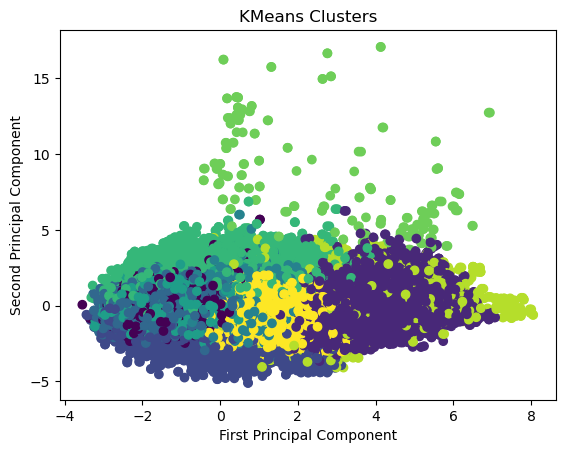

In [4]:
# Visualize the clusters
def visualize_clusters(df, model):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(df)
    plt.scatter(pc[:, 0], pc[:, 1], c=model.labels_)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('KMeans Clusters')
    plt.show()

visualize_clusters(pp_df, model)

In [5]:
# Show a sample of songs from each cluster
def show_cluster_samples(df, model, n_samples):
    df['cluster'] = model.labels_
    for cluster in range(model.n_clusters):
        print(f'Cluster {cluster}:')
        sample = df[df['cluster'] == cluster].sample(n=n_samples)
        print(sample[['track_name', 'artist_name', 'popularity']])
        print('\n')

show_cluster_samples(original_df, model, 3)


Cluster 0:
            track_name        artist_name  popularity
19247        Telephone  Perpetuum Jazzile           0
32233   Walk That Walk        G-Train MMF           0
126928            Grip               Seeb          59


Cluster 1:
                                               track_name  \
105560      Fêtes galantes Livre II, L. 104: II. Le Faune   
49825   Piano Sonata No. 2 in A Major, Op. 2 No. 2: II...   
99909   Oboe Concerto in C Major, K. 314: III. Rondo. ...   

                    artist_name  popularity  
105560           Claude Debussy           5  
49825      Ludwig van Beethoven          15  
99909   Wolfgang Amadeus Mozart          16  


Cluster 2:
                                      track_name           artist_name  \
112881                               Fuck Wit Me                REASON   
85513                          Count Money on Em  Baby blue tha prince   
2099    Group Therapy (Messages Pt. 3) [ABGT282]        Above & Beyond   

        popularity  


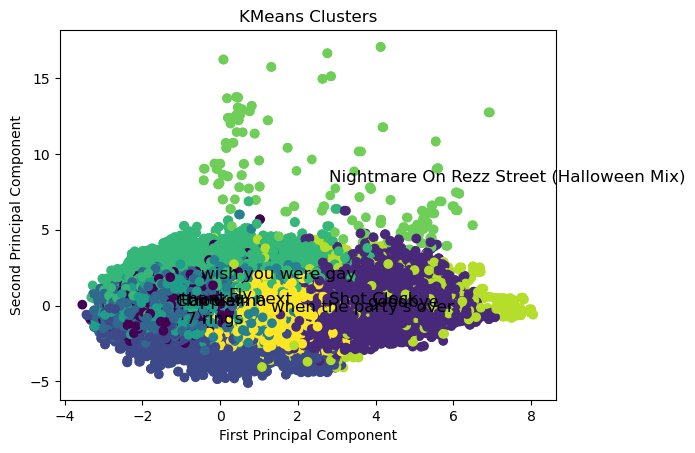

In [6]:
# Visualize clusters with most popular songs
def visualize_clusters_with_songs(df, original_df, model):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(df)
    plt.scatter(pc[:, 0], pc[:, 1], c=model.labels_)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('KMeans Clusters')
    for cluster in range(model.n_clusters):
        cluster_indices = np.where(model.labels_ == cluster)[0]
        cluster_center = pc[cluster_indices].mean(axis=0)
        popular_song = original_df[original_df['cluster'] == cluster].sort_values('popularity', ascending=False).iloc[0]
        plt.text(cluster_center[0], cluster_center[1], popular_song['track_name'], fontsize=12)
    plt.show()

# Add 'cluster' column to the original dataframe
original_df['cluster'] = model.labels_
visualize_clusters_with_songs(pp_df, original_df, model)

In [7]:
# Recommend a song from a given cluster
def recommend_songs(df, model, cluster):
    indices = np.where(df['cluster'] == cluster)[0]
    songs = df.iloc[indices]
    song = songs.sample()
    return song[['track_name', 'artist_name', 'popularity']]

# Recommend a song from cluster 0
print(recommend_songs(original_df, model, 0))

       track_name artist_name  popularity
112798   Your Own       SALES          56


In [19]:
'''This Block creates a function to:
1. Take a song name and artist name as input.
2. Get audio features for a song using the Spotify API.
3. Run the KMeans model to predict the cluster for the song.
4. Recommend a song from the same cluster as the input song.
'''

# Create a function to get audio features for a song using the Spotify API
def get_audio_features_from_spotify(song_name, artist_name, client_id, client_secret):
    # Initialize Spotipy API client
    sp = spotipy.Spotify(client_credentials_manager=spotipy.oauth2.SpotifyClientCredentials(client_id, client_secret))
    # Search for the song
    results = sp.search(q=f'track:{song_name} artist:{artist_name}', limit=1)
    # Get the track ID
    track_id = results['tracks']['items'][0]['id']
    # Get the audio features
    audio_features = sp.audio_features(track_id)[0]
    return audio_features

'''# Create a function to recommend a song from the same cluster as the input song
def recommend_song_from_cluster(df, model, song_name, artist_name, client_id, client_secret):
    # Get audio features for the input song
    audio_features = get_audio_features_from_spotify(song_name, artist_name, client_id, client_secret)
    # Preprocess the audio features
    scaler = StandardScaler()
    pp_audio_features = scaler.fit_transform(np.array(list(audio_features.values())[2:-1]).reshape(1, -1))
    # Predict the cluster for the input song
    cluster = model.predict(pp_audio_features)[0]
    # Recommend a song from the same cluster
    return recommend_songs(df, model, cluster)'''

def recommend_song_from_cluster(df, model, song_name, artist_name, client_id, client_secret):
    # Get audio features for the input song
    audio_features = get_audio_features_from_spotify(song_name, artist_name, client_id, client_secret)
    
    # Specify the relevant audio feature keys (example keys, adjust based on your model's needs)
    audio_keys = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'popularity']
    relevant_features = [audio_features[key] for key in audio_keys if key in audio_features]
    
    # Preprocess the audio features
    scaler = StandardScaler()
    pp_audio_features = scaler.fit_transform(np.array(relevant_features).reshape(1, -1))
    
    # Predict the cluster for the input song
    cluster = model.predict(pp_audio_features)[0]
    
    # Recommend a song from the same cluster
    return recommend_songs(df, model, cluster)

# Test the function with "Affection" by Crystal Castles
print(recommend_song_from_cluster(original_df, model, 'Affection', 'Crystal Castles', client_id, client_secret))

ValueError: X has 13 features, but KMeans is expecting 14 features as input.

In [28]:
# Create a function to get audio features for a song using the Spotify API
def get_audio_features_from_spotify(song_name, artist_name, client_id, client_secret):
    # Initialize Spotipy API client
    sp = spotipy.Spotify(client_credentials_manager=spotipy.oauth2.SpotifyClientCredentials(client_id, client_secret))
    # Search for the song
    results = sp.search(q=f'track:{song_name} artist:{artist_name}', limit=1)
    # Handle the case where the song is not found
    if not results['tracks']['items']:
        return None
    # Get the track ID
    track_id = results['tracks']['items'][0]['id']
    # Get the audio features
    audio_features = sp.audio_features(track_id)[0]
    return audio_features

# Create a function to recommend a song from the same cluster as the input song
def recommend_song_from_cluster(df, model, song_name, artist_name, client_id, client_secret):
    # Get audio features for the input song
    audio_features = get_audio_features_from_spotify(song_name, artist_name, client_id, client_secret)
    if not audio_features:
        return "Song not found in Spotify database."
    
    # Specify the relevant audio feature keys
    audio_keys = [ 
        'acousticness', 'danceability', 'duration_ms', 'energy', 
        'instrumentalness', 'key', 'liveness', 'loudness', 
        'mode', 'speechiness', 'tempo' ,'time_signature',
        'valence', 'popularity'
    ]
    
    # Ensure all keys are present in the audio features and fill missing keys with 0
    relevant_features = [audio_features.get(key, 0) for key in audio_keys]
    
    # Preprocess the audio features using the existing scaler
    pp_audio_features = scaler.transform(np.array(relevant_features).reshape(1, -1))
    
    # Predict the cluster for the input song
    cluster = model.predict(pp_audio_features)[0]
    
    # Recommend a song from the same cluster
    return recommend_songs(df, model, cluster)

# Test the function with "Affection" by Crystal Castles
print(recommend_song_from_cluster(original_df, model, 'Affection', 'Crystal Castles', client_id, client_secret))



       track_name    artist_name  popularity
100402      Maska  Chinar Mahesh           0


c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
